In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/xai-lab/detection')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [3]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

## Finetune the pre-trained model

In [4]:
# load an instance segmentation model pre-trained pre-trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
# move the model to the right device
model.to(device) 

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## Define the dataset

In [5]:
from pennfudan_dataset import PennFudanDataset, get_transform
from utils import collate_fn

# use our dataset and defined transformations
dataset = PennFudanDataset('../PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('../PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=collate_fn)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Training settings

In [6]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [7]:
!pip install --upgrade torch==1.10.0
!pip install --upgrade torchvision

## Training

In [8]:
from engine import train_one_epoch, evaluate

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [ 0/60]  eta: 0:02:16  lr: 0.000090  loss: 3.8290 (3.8290)  loss_classifier: 0.8322 (0.8322)  loss_box_reg: 0.2190 (0.2190)  loss_mask: 2.7521 (2.7521)  loss_objectness: 0.0227 (0.0227)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 2.2734  data: 0.3048  max mem: 2658
Epoch: [0]  [10/60]  eta: 0:01:25  lr: 0.000936  loss: 1.7180 (2.4063)  loss_classifier: 0.4852 (0.5012)  loss_box_reg: 0.2690 (0.3193)  loss_mask: 0.9969 (1.5559)  loss_objectness: 0.0238 (0.0236)  loss_rpn_box_reg: 0.0052 (0.0062)  time: 1.7067  data: 0.0399  max mem: 3238
Epoch: [0]  [20/60]  eta: 0:01:08  lr: 0.001783  loss: 1.0513 (1.6688)  loss_classifier: 0.2423 (0.3598)  loss_box_reg: 0.3529 (0.3298)  loss_mask: 0.4272 (0.9520)  loss_objectness: 0.0128 (0.0210)  loss_rpn_box_reg: 0.0055 (0.0064)  time: 1.6886  data: 0.0132  max mem: 3238
Epoch: [0]  [30/60]  eta: 0:00:50  lr: 0.002629  loss: 0.7061 (1.3017)  loss_classifier: 0.1112 (0.2679)  loss_box_reg: 0.3494 (0.3018)  loss_mask: 0.2102 (0.7075)  loss_ob

## Visualization

In [9]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [10]:
prediction

[{'boxes': tensor([[229.1803,  60.2040, 391.3603, 353.4232],
          [113.9147,  77.2495, 189.6049, 257.6299],
          [ 43.1293,  85.9930,  93.4542, 254.2630],
          [207.9981,  67.6680, 262.7140, 254.7994],
          [310.5108,  59.6509, 383.7855, 265.6788],
          [179.6940,  55.7538, 234.4388, 250.1759],
          [111.7195,  66.6157, 148.6016, 250.5532],
          [ 58.3018,  75.0905, 222.1679, 256.4473],
          [202.6461,  60.2250, 297.9602, 311.5420],
          [170.1972,  46.7570, 268.4603, 310.9012],
          [248.7785,  67.6519, 335.3006, 296.1631]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ...,

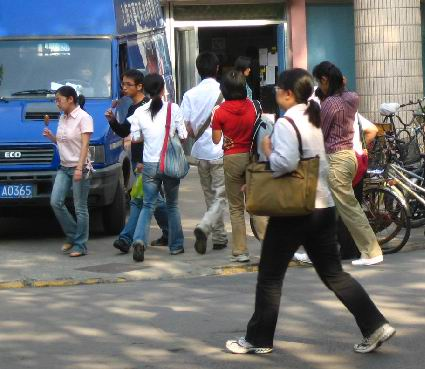

In [11]:
from PIL import Image
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

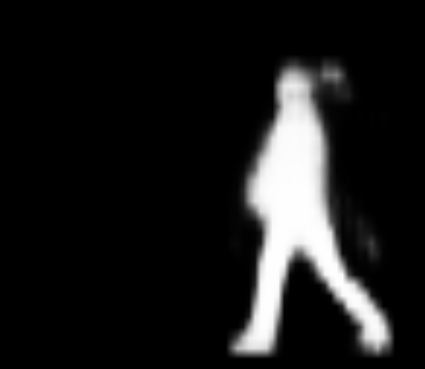

In [12]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

### Plot the mask back on the original image

cr. https://pytorch.org/vision/master/auto_examples/plot_visualization_utils.html#instance-segmentation-models

In [13]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

shape = torch.Size([11, 1, 369, 425]), dtype = torch.bool


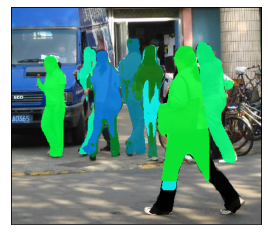

In [20]:
from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks

proba_threshold = 0.5
# score_threshold = 0.75 # Select detections with good scores
bool_masks = prediction[0]['masks'] > proba_threshold
# bool_masks = prediction[0]['masks'][prediction[0]['scores'] > score_threshold] > proba_threshold
print(f"shape = {bool_masks.shape}, dtype = {bool_masks.dtype}")

img_int = read_image(str('../PennFudanPed/PNGImages/FudanPed00025.png'))
# There's an extra dimension (1) to the masks. We need to remove it
bool_masks = bool_masks.squeeze(1)
show(draw_segmentation_masks(img_int, bool_masks, alpha=0.9)) 